In [2]:
# change kernel for this file to the virtual environmnt and not base. 

import sys
from datetime import date, timedelta

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Load Dataset
number_of_days = 360
gold_prices = yf.download("GOLD", start=str(date.today()- timedelta(days=number_of_days)), end=str(date.today()), auto_adjust=True)[['Close']].copy()

[*********************100%%**********************]  1 of 1 completed


## Backtesting Model Strategy
Starting with an initial balance, in chronological order invest all of it into the asset on the day when predicted (next day) price is greater than current price, and sell all of it on the first day when predicted (next day) price is less than current price to lock in the profit. Repeat the strategy for the duration of the forecasting timeline.

#### Key Assumptions:
1. Trades conducted have no impact on asset prices. This is, of course, a key weakness affecting backtesting for all the trading strategies, since any actual significant transaction would impact the price of the asset. For the purposes of this example, however, backtesting is employed to compare the relative performances between models as opposed to evaluate the absolute returns of any investment over a period of time.
2. There are no transaction costs.
3. Settlement is immediate allowing for daily execution of trades using the same allocated cash / security.


In [40]:
def final_position(available_funds, present_price_array, forecast_price_array):
    initial_balance = f"Initial Balance: USD{available_funds:.2f}"
    cash_balance = available_funds
    position = 0

    for i in range(len(present_price_array)):
        current_price = present_price_array[i]
        predicted_price = forecast_price_array[i]
        # Buy Condition
        if  current_price < predicted_price and current_price < cash_balance:
            quantity = int(cash_balance // current_price)
            position += quantity
            cash_balance -= quantity * current_price
            print(f"Order Confirmation: Buy {quantity} shares at USD{current_price:.2f}")

        # Sell Condition
        elif  current_price > predicted_price and  position > 0:
            position -= quantity
            cash_balance += quantity * current_price
            print(f"Order Confirmation: Sell {quantity} shares at USD{current_price:.2f}")
    
    final_position = f"Final Position: {position} Shares at {current_price:.2f}"
    final_profit = f"Profit: USD{(cash_balance - available_funds):.2f}"

    print('\n')
    print(initial_balance)
    print(final_position)
    print(final_profit) 


## Forecasting Model 1: Linear Regression 
##### Response Variable: Next Day Closing Price
##### Explanatory Variables: Current Day Closing Price, 5 and 20 weekday moving averages


In [41]:
# Calculate 5 weekday (1 week) and 20 weekday (1 month) moving averages
gold_prices['MA_5'] = gold_prices['Close'].rolling(7).mean()
gold_prices['MA_20'] = gold_prices['Close'].rolling(30).mean()

In [42]:
# Prepare dataset
X = gold_prices.copy().dropna()[:-1] # Do not include most recent day's price data since we do not have the next day's price to test its predictive capabilities.
y = gold_prices['Close'].shift(-1).dropna()[X.index[0]:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [43]:
# Deploy (fit) the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 0.11854036562362352
R² Score: 0.9232510172457383


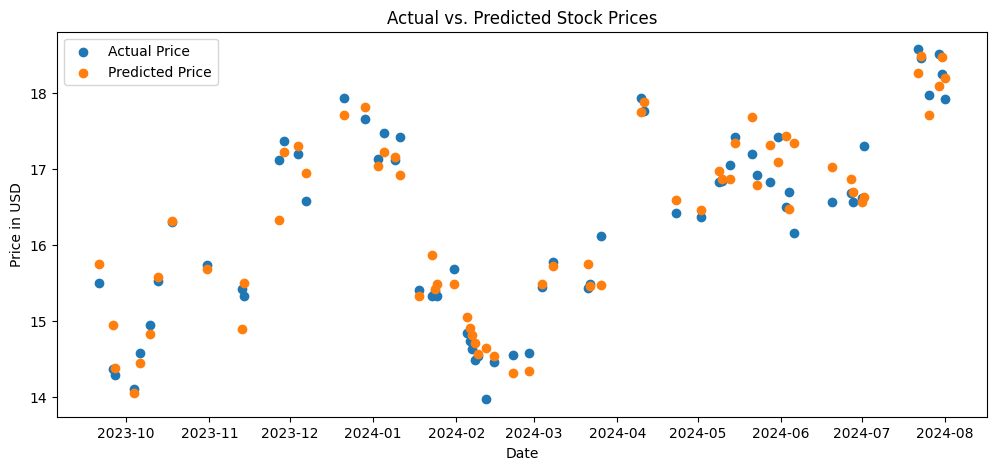

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.scatter(y_test.index, y_test.values, label='Actual Price')
plt.scatter(y_test.index, predictions, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

In [45]:
# Backtesting

available_funds = 10000
present_price_array =  X_test['Close']
forecast_price_array = predictions
final_position(available_funds, present_price_array, forecast_price_array)

Order Confirmation: Buy 594 shares at USD16.83
Order Confirmation: Sell 594 shares at USD17.00
Order Confirmation: Buy 641 shares at USD15.74
Order Confirmation: Sell 641 shares at USD18.51
Order Confirmation: Buy 800 shares at USD14.84
Order Confirmation: Sell 800 shares at USD15.69
Order Confirmation: Buy 758 shares at USD16.56
Order Confirmation: Sell 758 shares at USD17.18
Order Confirmation: Buy 828 shares at USD15.72
Order Confirmation: Sell 828 shares at USD17.86
Order Confirmation: Buy 996 shares at USD14.85
Order Confirmation: Sell 996 shares at USD16.49
Order Confirmation: Buy 1063 shares at USD15.45
Order Confirmation: Sell 1063 shares at USD16.59
Order Confirmation: Buy 1238 shares at USD14.25
Order Confirmation: Sell 1238 shares at USD17.34
Order Confirmation: Buy 1462 shares at USD14.69
Order Confirmation: Sell 1462 shares at USD17.09
Order Confirmation: Buy 1619 shares at USD15.43
Order Confirmation: Sell 1619 shares at USD17.11
Order Confirmation: Buy 1987 shares at USD

/var/folders/sr/p8nh5gq10rg0n05drjt3xczh0000gn/T/ipykernel_3410/3526853153.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = present_price_array[i]
